In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib import wrap_labels, adjust_pairplot_axes

In [5]:
sql = """
with by_zip as (
    SELECT
        CASE WHEN is_harlem THEN 'Harlem'
            WHEN borough_name = 'Manhattan' THEN 'Manhattan (Except Harlem)'
            ELSE borough_name END AS borough_name,
        sum(population_2020_estimate) as population_2020_estimate,
        sum(total_admissions_3_2019) AS total_admissions_3_2019,
        sum(otp_capacity) AS otp_capacity,
        sum(avg_daily_enrollment_2019) AS avg_daily_enrollment_2019,
        sum(patient_admissions_3_2019) AS patient_admissions_3_2019,
        sum(opioid_burden_2019) AS opioid_burden_2019
    FROM zip_code_otp_analysis
    GROUP BY 1
), by_uhf as (
    SELECT
        CASE WHEN is_harlem THEN 'Harlem'
            WHEN borough_name = 'Manhattan' THEN 'Manhattan (Except Harlem)'
            ELSE borough_name END AS borough_name,
        sum(overdose_deaths_2020) as overdose_deaths_2020
    FROM uhf_otp_analysis
    GROUP BY 1
   
)
select
    borough_name,
    coalesce(total_admissions_3_2019, 0) AS "Estimated OTP Admissions (2019)",
    coalesce(otp_capacity, 0) AS "Reported OTP Capacity (2019)",
    coalesce(avg_daily_enrollment_2019, 0) AS "Reported Daily Avg OTP Enrollment (2019)",
    coalesce(patient_admissions_3_2019, 0) AS "Estimated OTP Patient Residents (2019)",
    coalesce(opioid_burden_2019, 0) AS "Opioid Burden (2019)",
    coalesce(overdose_deaths_2020, 0) AS "Overdose Deaths (2020)",
    population_2020_estimate AS "Estimated Population (2020)"
from by_zip
    full outer join by_uhf using (borough_name)
"""
df = pd.read_sql(sql, con=db_url)


for c in [
    'borough_name'
]:
    df[c] = pd.Categorical(df[c])


,Estimated OTP Admissions (2019),Reported OTP Capacity (2019),Reported Daily Avg OTP Enrollment (2019),Estimated OTP Patient Residents (2019),Opioid Burden (2019),Overdose Deaths (2020),Estimated Population (2020)
borough_name,,,,,,,
Bronx,0.262426,0.313380,0.325445,0.322242,0.298233,0.299217,0.171389
Brooklyn,0.173882,0.214344,0.208972,0.238108,0.274137,0.236577,0.308477
Manhattan (Except Harlem),0.273523,0.251799,0.240011,0.162638,0.174353,0.123043,0.158721
Queens,0.096671,0.049784,0.055355,0.157959,0.130723,0.200783,0.271172
Harlem,0.176305,0.146599,0.145385,0.069318,0.054579,0.066555,0.033305
Staten Island,0.017193,0.024094,0.024831,0.049736,0.067974,0.073826,0.056936


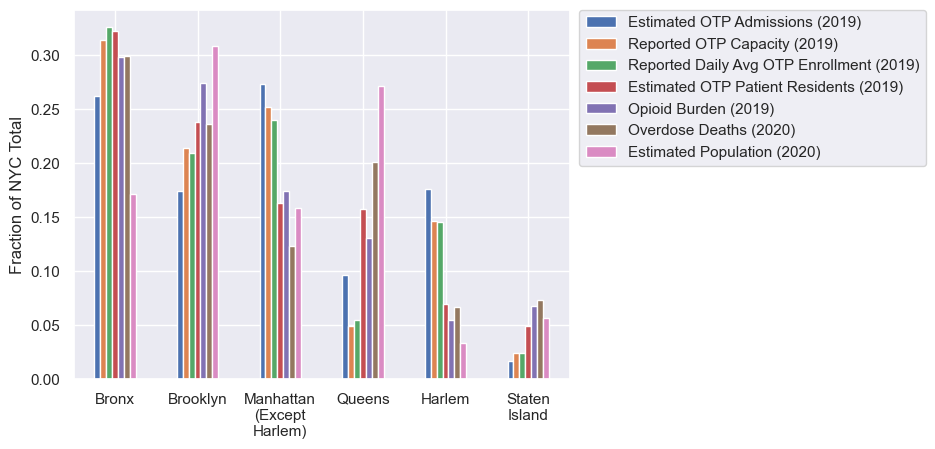

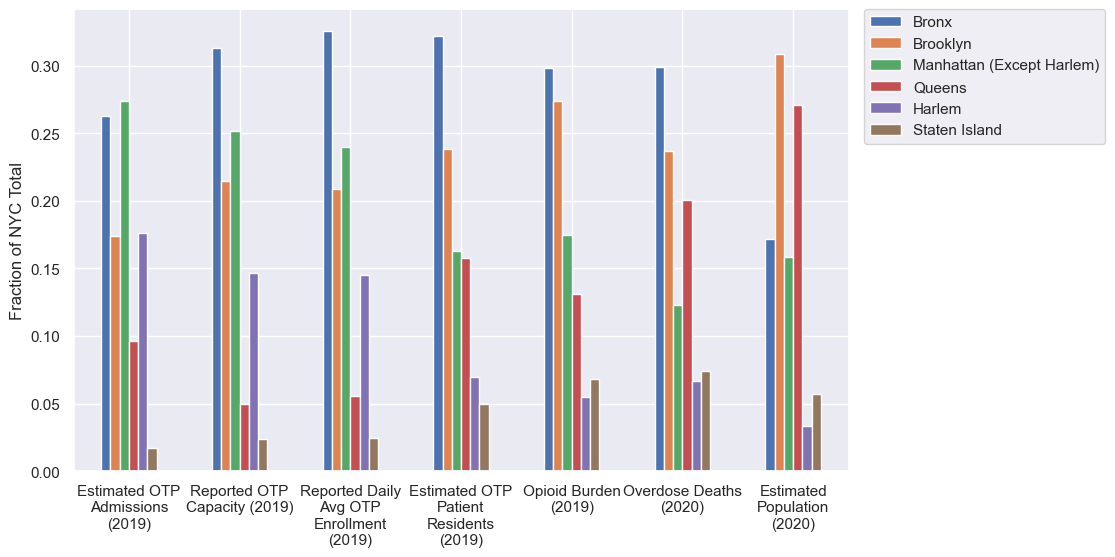

In [6]:
borough_program_metrics = df[[
    'Estimated OTP Admissions (2019)',
    'Reported OTP Capacity (2019)',
    'Reported Daily Avg OTP Enrollment (2019)',
    'Estimated OTP Patient Residents (2019)',
    'Opioid Burden (2019)',
    "Overdose Deaths (2020)",
    "Estimated Population (2020)",
]].groupby(df['borough_name']).sum()
borough_program_metrics = borough_program_metrics / borough_program_metrics.sum()
borough_program_metrics = borough_program_metrics.sort_values('Estimated OTP Patient Residents (2019)', ascending=False)
ax = borough_program_metrics.plot(
    kind='bar', 
    xlabel='',
    ylabel='Fraction of NYC Total'
)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
wrap_labels(ax, 10)

# Sort of easier to see pivoted
ax2 = borough_program_metrics.T.plot(
    kind='bar', 
    ylabel='Fraction of NYC Total',
    figsize=(10,6)
)
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xticks(rotation=0)
wrap_labels(ax2, 15)

borough_program_metrics

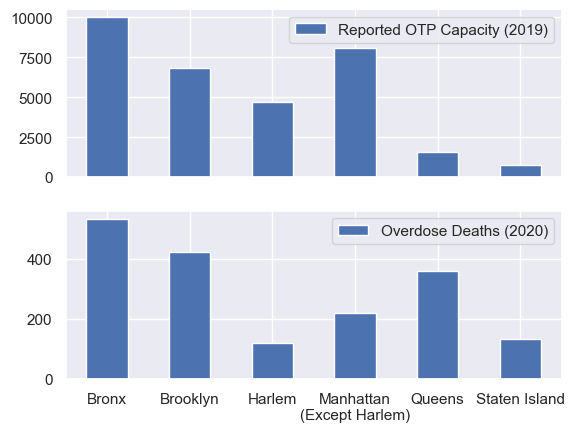

In [28]:
# Can I reproduce anything off?

borough_totals = df[[
    'Reported OTP Capacity (2019)',
    'Estimated OTP Patient Residents (2019)',
    "Overdose Deaths (2020)",
]].groupby(df['borough_name']).sum().reset_index()
fig, axes = plt.subplots(2, 1, sharex=True)

borough_totals.plot(kind='bar', 
    x='borough_name', 
    y='Reported OTP Capacity (2019)', 
    ax=axes[0],
    xlabel=''
)
borough_totals.plot(kind='bar', 
    x='borough_name', 
    y='Overdose Deaths (2020)', 
    ax=axes[1],
    xlabel=''
)
wrap_labels(axes[1], 15)